In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import yaml

path_to_experiments = "./"
#get all experiment folders
experiment_folders = [f.path for f in os.scandir(path_to_experiments) if f.is_dir()]   


In [2]:
#for each folder split the name by _ and get parameters
df = pd.DataFrame(columns=["folder", "sample_size", "volume_depth","run_number", "batch_number", "list_of_pixel_score"])
for folder in experiment_folders:
    params = folder.split("_")
    sample_size = int(params[1])
    volume_depth = int(params[2])
    run_files = [f.path for f in os.scandir(folder) if f.is_file() and "run" in f.name]
    for run_file in run_files:
        run_number = run_file.split("_")[-1].split(".")[0]
        with open(run_file, 'r') as f:
            run_data = yaml.safe_load(f)
        batch_numbers = list(run_data.keys())
        for batch_number in batch_numbers:
            number = int(batch_number.split("_")[-1])
            #save pixelscore as np array
            pixel_scores = np.array(run_data[batch_number])
            df = pd.concat([df, pd.DataFrame([[folder, sample_size, volume_depth, run_number, number, pixel_scores]], columns=df.columns)], ignore_index=True)    

In [3]:
df.head(),df.tail()

(                     folder sample_size volume_depth run_number batch_number  \
 0  ./condDDPM_16_32_0.6_0.4          16           32          3            0   
 1  ./condDDPM_16_32_0.6_0.4          16           32          3            1   
 2  ./condDDPM_16_32_0.6_0.4          16           32          3           10   
 3  ./condDDPM_16_32_0.6_0.4          16           32          3           11   
 4  ./condDDPM_16_32_0.6_0.4          16           32          3           12   
 
                                  list_of_pixel_score  
 0  [188, 163, 197, 151, 194, 183, 185, 163, 180, ...  
 1  [149, 156, 130, 183, 168, 175, 139, 246, 124, ...  
 2  [114, 200, 235, 62, 187, 219, 164, 160, 208, 1...  
 3  [150, 150, 192, 138, 181, 190, 99, 122, 238, 1...  
 4  [149, 61, 188, 138, 146, 107, 216, 170, 239, 2...  ,
                        folder sample_size volume_depth run_number  \
 2290  ./condDDPM_16_8_0.6_0.4          16            8          0   
 2291  ./condDDPM_16_8_0.6_0.4     

In [4]:
#normalize pixel scores by using samples_size**2 as the maximum possible score, read the sample_size from the folder name
df["normalized_pixel_score"] = df["list_of_pixel_score"] / (df["sample_size"].astype(int) ** 2)

In [5]:
#create mean, std, min, max columns for normalized_pixel_score
df["mean_normalized_pixel_score"] = df["normalized_pixel_score"].apply(np.mean)
df["std_normalized_pixel_score"] = df["normalized_pixel_score"].apply(np.std)
df["min_normalized_pixel_score"] = df["normalized_pixel_score"].apply(np.min)
df["max_normalized_pixel_score"] = df["normalized_pixel_score"].apply(np.max)

In [6]:
# for run 0 combine all batches into one list 
df_run0 = df[df["run_number"] == "0"].copy()
df_run0 = df_run0.groupby(["sample_size", "volume_depth"]).agg({
    "normalized_pixel_score": lambda x: np.concatenate(x.values)
}).reset_index()

In [7]:
#for each entry in df_run0 get the mean, std, min, max of normalized_pixel_score 
df_run0['mean'] = df_run0["normalized_pixel_score"].apply(np.mean)
df_run0['std'] = df_run0["normalized_pixel_score"].apply(np.std)
df_run0['min'] = df_run0["normalized_pixel_score"].apply(np.min)
df_run0['max']= df_run0["normalized_pixel_score"].apply(np.max)
df_run0.head()

,sample_size,volume_depth,normalized_pixel_score,mean,std,min,max
0,8,8,"[0.640625, 0.796875, 0.671875, 0.5625, 0.32812...",0.524668,0.211022,0.000000,1.000000
1,8,16,"[0.53125, 0.6875, 0.578125, 0.484375, 0.625, 0...",0.510405,0.213634,0.046875,1.000000
2,8,32,"[0.5625, 0.546875, 0.40625, 0.46875, 0.140625,...",0.497922,0.240763,0.015625,1.000000
3,16,8,"[0.68359375, 0.6953125, 0.6953125, 0.74609375,...",0.641668,0.139478,0.164062,0.988281
4,16,16,"[0.50390625, 0.5546875, 0.515625, 0.75390625, ...",0.599027,0.100080,0.222656,0.964844


In [8]:
def build_run_df(df,run_number):
    df_run = df[df["run_number"] == str(run_number)].copy()
    df_run = df_run.groupby(["sample_size", "volume_depth"]).agg({
        "normalized_pixel_score": lambda x: np.concatenate(x.values)
    }).reset_index()

    #for each entry in df_run get the mean, std, min, max of normalized_pixel_score 
    df_run['mean'] = df_run["normalized_pixel_score"].apply(np.mean)
    df_run['std'] = df_run["normalized_pixel_score"].apply(np.std)
    df_run['min'] = df_run["normalized_pixel_score"].apply(np.min)
    df_run['max']= df_run["normalized_pixel_score"].apply(np.max)
    return df_run

df_run0 = build_run_df(df,0)
df_run1 = build_run_df(df,1)
df_run2 = build_run_df(df,2)
df_run3 = build_run_df(df,3)
df_run4 = build_run_df(df,4)

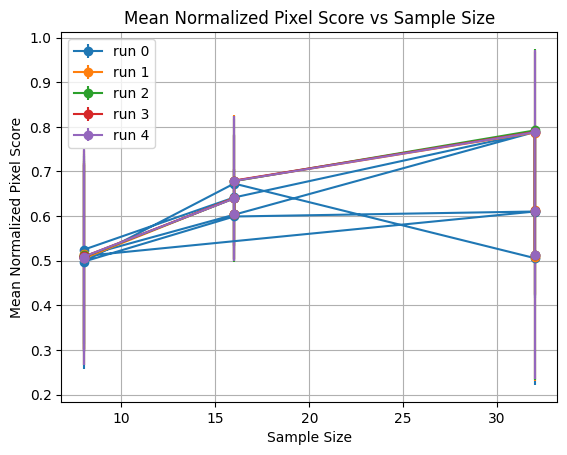

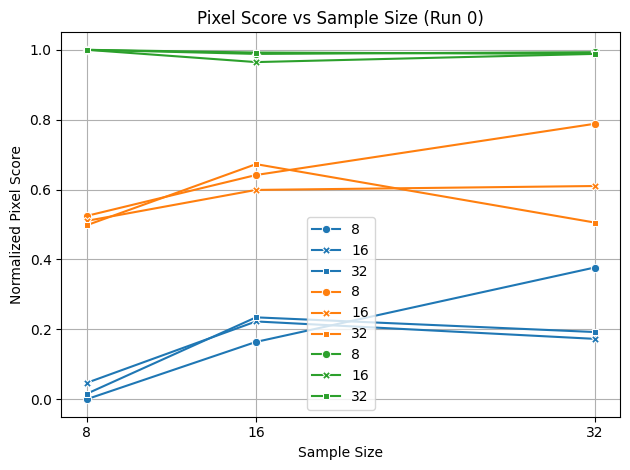

In [25]:
#plot mean, min, max against sample_size
import seaborn as sns
plt.figure()
sample_sizes = df_run0["sample_size"].astype(int).unique()
#plt.plot(sample_sizes, df_run0["mean"], label="Mean", marker='o')
#plt.fill_between(sample_sizes, df_run0["min"], df_run0["max"], color='gray', alpha=0.2, label="Min-Max Range")
#sort dfrun0 by sample_size
df_run0 = df_run0.sort_values(by="sample_size")
sns.lineplot(x="sample_size", y="min", data=df_run0, style="volume_depth", markers=True, dashes=False)
sns.lineplot(x="sample_size", y="mean", data=df_run0, style="volume_depth", markers=True, dashes=False)
sns.lineplot(x="sample_size", y="max", data=df_run0, style="volume_depth", markers=True, dashes=False)
#plot a channel around mean using std
plt.xlabel("Sample Size")
plt.ylabel("Normalized Pixel Score")
plt.title("Pixel Score vs Sample Size (Run 0)")
#space the xticks to be only 8,16,32 and evenly
plt.xticks(sample_sizes)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


   sample_size  volume_depth  \
0            8             8   
3           16             8   
6           32             8   
1            8            16   
7           32            16   

                              normalized_pixel_score      mean       std  \
0  [0.640625, 0.796875, 0.671875, 0.5625, 0.32812...  0.524668  0.211022   
3  [0.68359375, 0.6953125, 0.6953125, 0.74609375,...  0.641668  0.139478   
6  [0.974609375, 0.7646484375, 0.6748046875, 0.98...  0.788251  0.180068   
1  [0.53125, 0.6875, 0.578125, 0.484375, 0.625, 0...  0.510405  0.213634   
7  [0.55078125, 0.5673828125, 0.607421875, 0.4960...  0.610194  0.193088   

        min       max  
0  0.000000  1.000000  
3  0.164062  0.988281  
6  0.376953  0.993164  
1  0.046875  1.000000  
7  0.172852  0.988281  


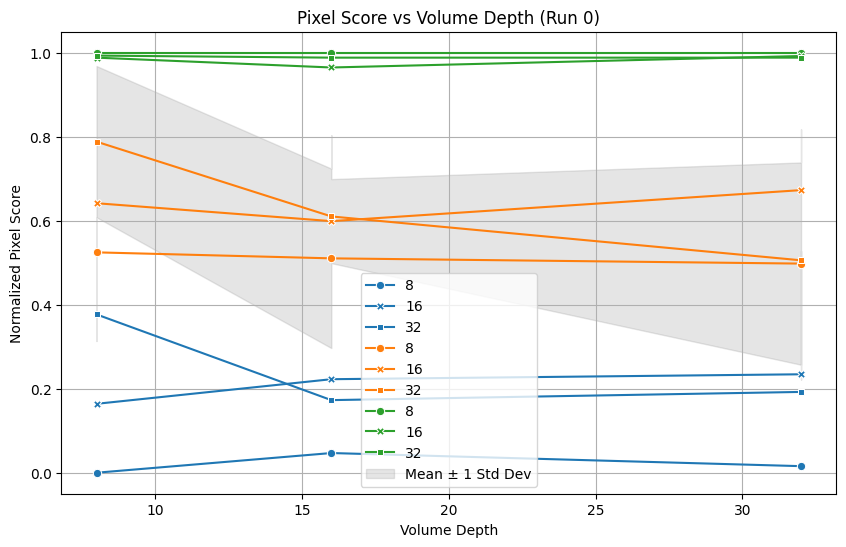

In [10]:
#plot mean, min, max against volume_depth
import seaborn as sns
plt.figure(figsize=(10,6))
sample_sizes = df_run0["volume_depth"].astype(int).unique()
#plt.plot(sample_sizes, df_run0["mean"], label="Mean", marker='o')
#plt.fill_between(sample_sizes, df_run0["min"], df_run0["max"], color='gray', alpha=0.2, label="Min-Max Range")
#sort dfrun0 by sample_size
df_run0 = df_run0.sort_values(by="volume_depth")
print(df_run0.head())
sns.lineplot(x="volume_depth", y="min", data=df_run0, style="sample_size", markers=True, dashes=False)
sns.lineplot(x="volume_depth", y="mean", data=df_run0, style="sample_size", markers=True, dashes=False)
sns.lineplot(x="volume_depth", y="max", data=df_run0, style="sample_size", markers=True, dashes=False)
#plot a channel around mean using std
plt.fill_between(df_run0["volume_depth"], df_run0["mean"] - df_run0["std"], df_run0["mean"] + df_run0["std"], color='gray', alpha=0.2, label="Mean ± 1 Std Dev")
plt.xlabel("Volume Depth")
plt.ylabel("Normalized Pixel Score")
plt.title("Pixel Score vs Volume Depth (Run 0)")
plt.legend()
plt.grid()
plt.show()


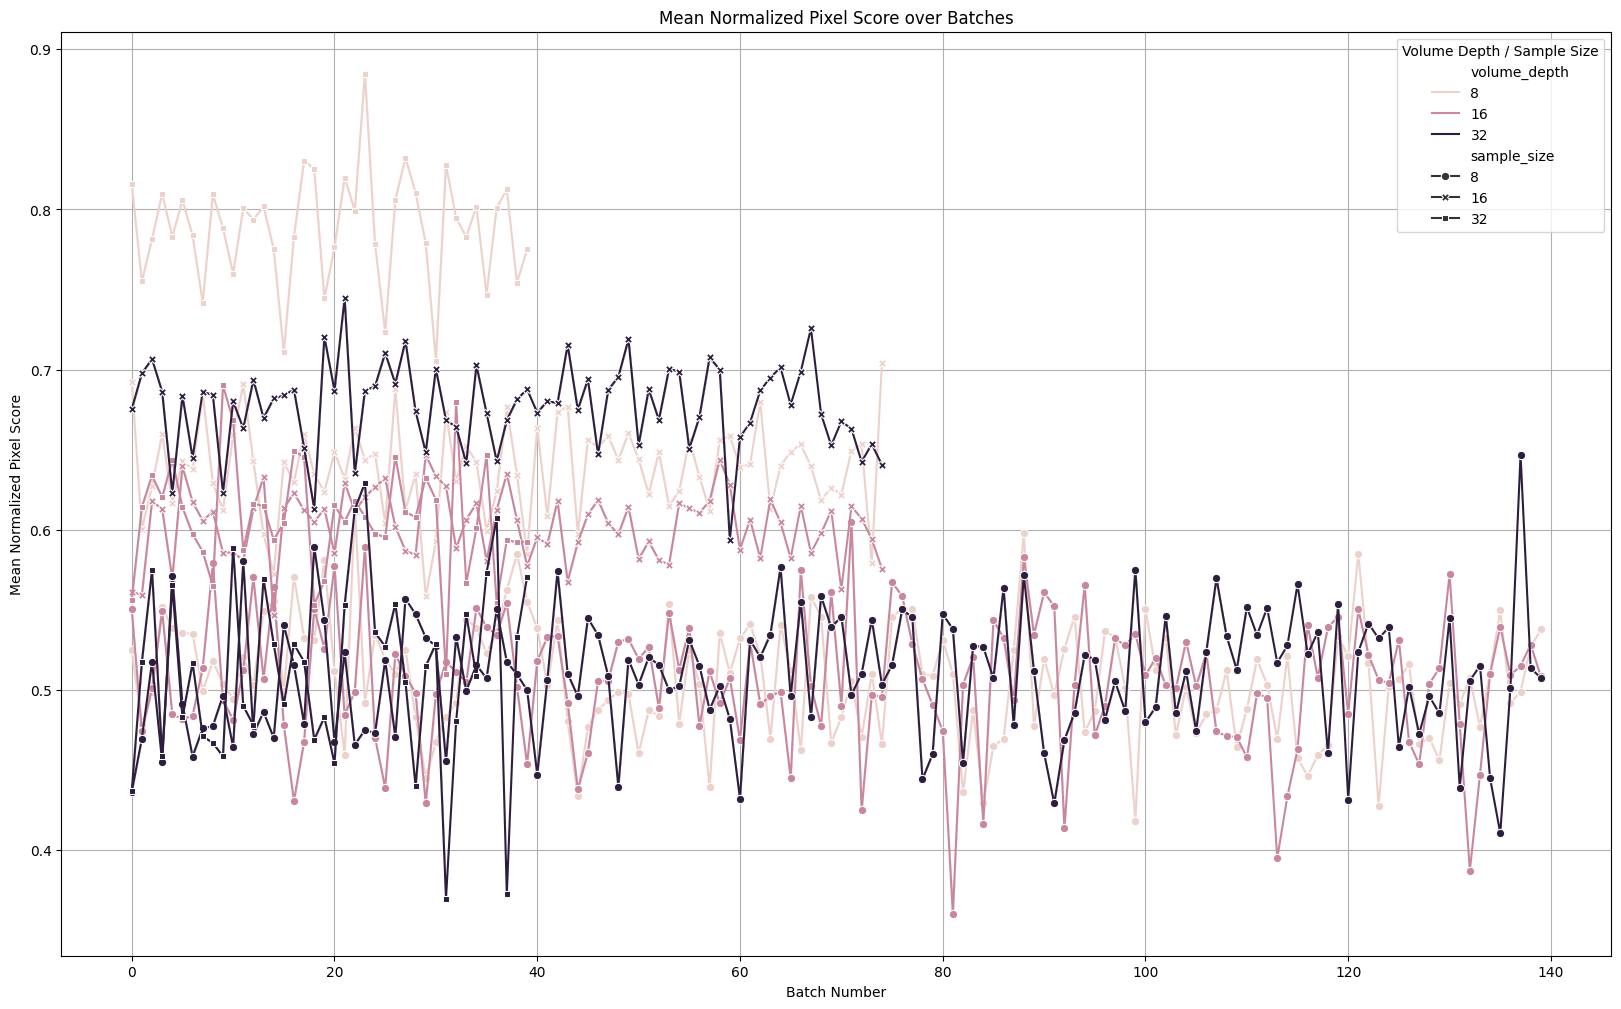

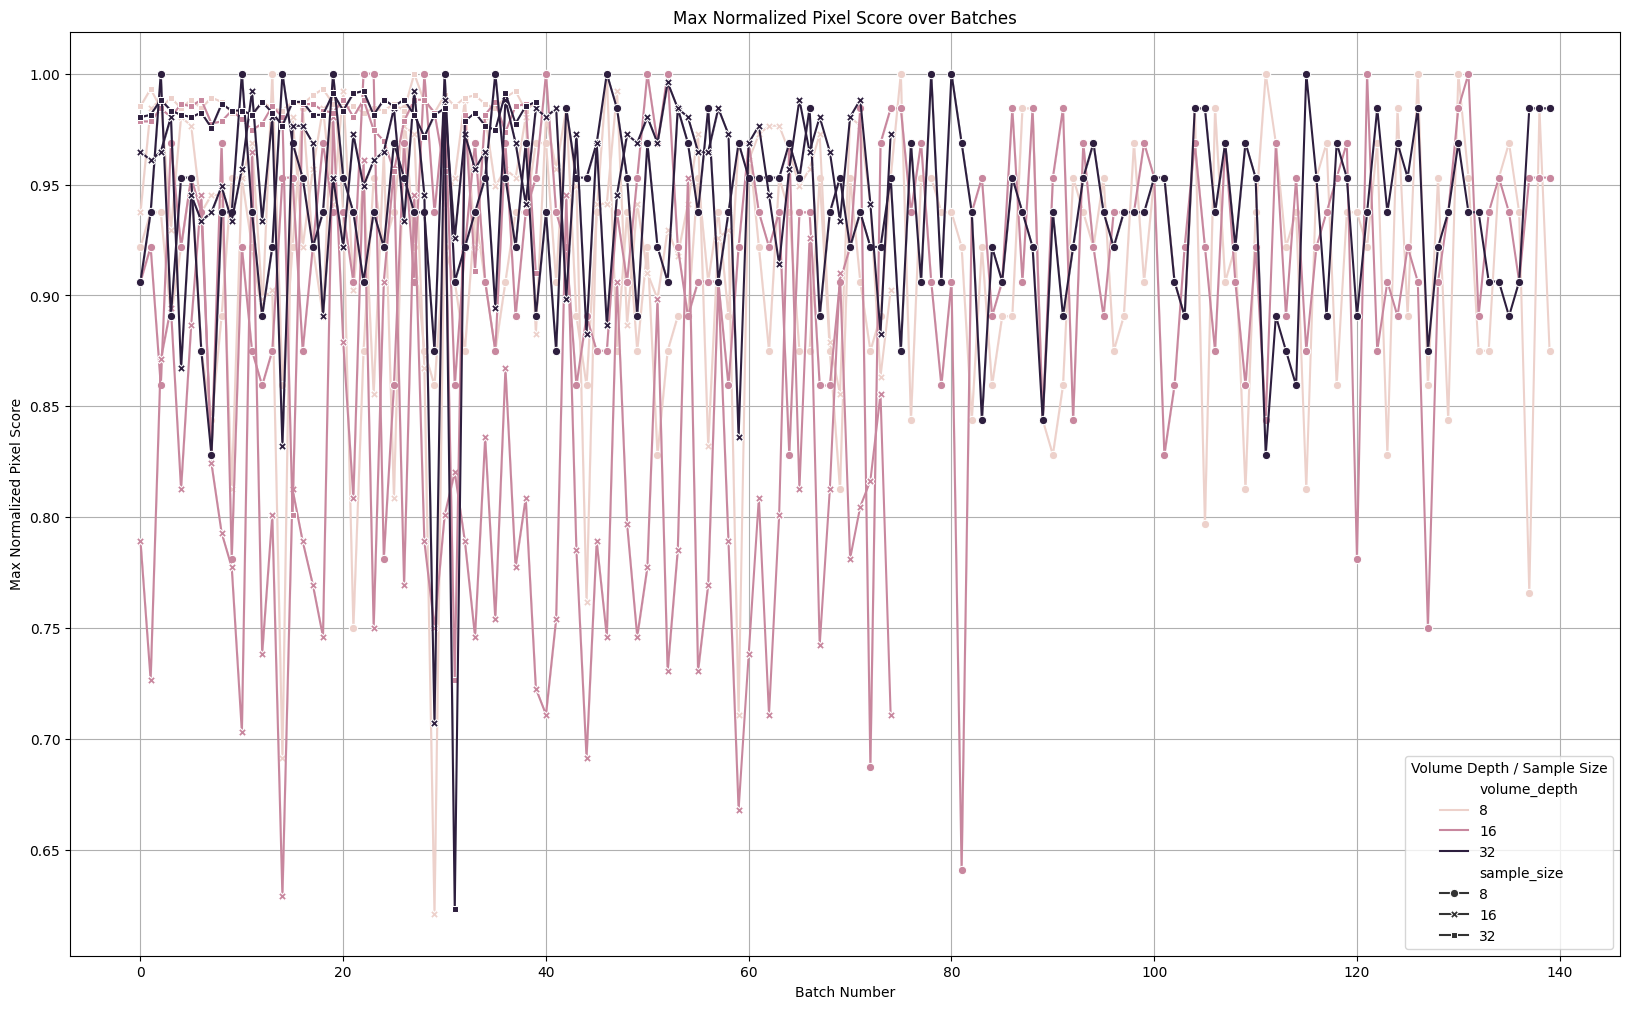

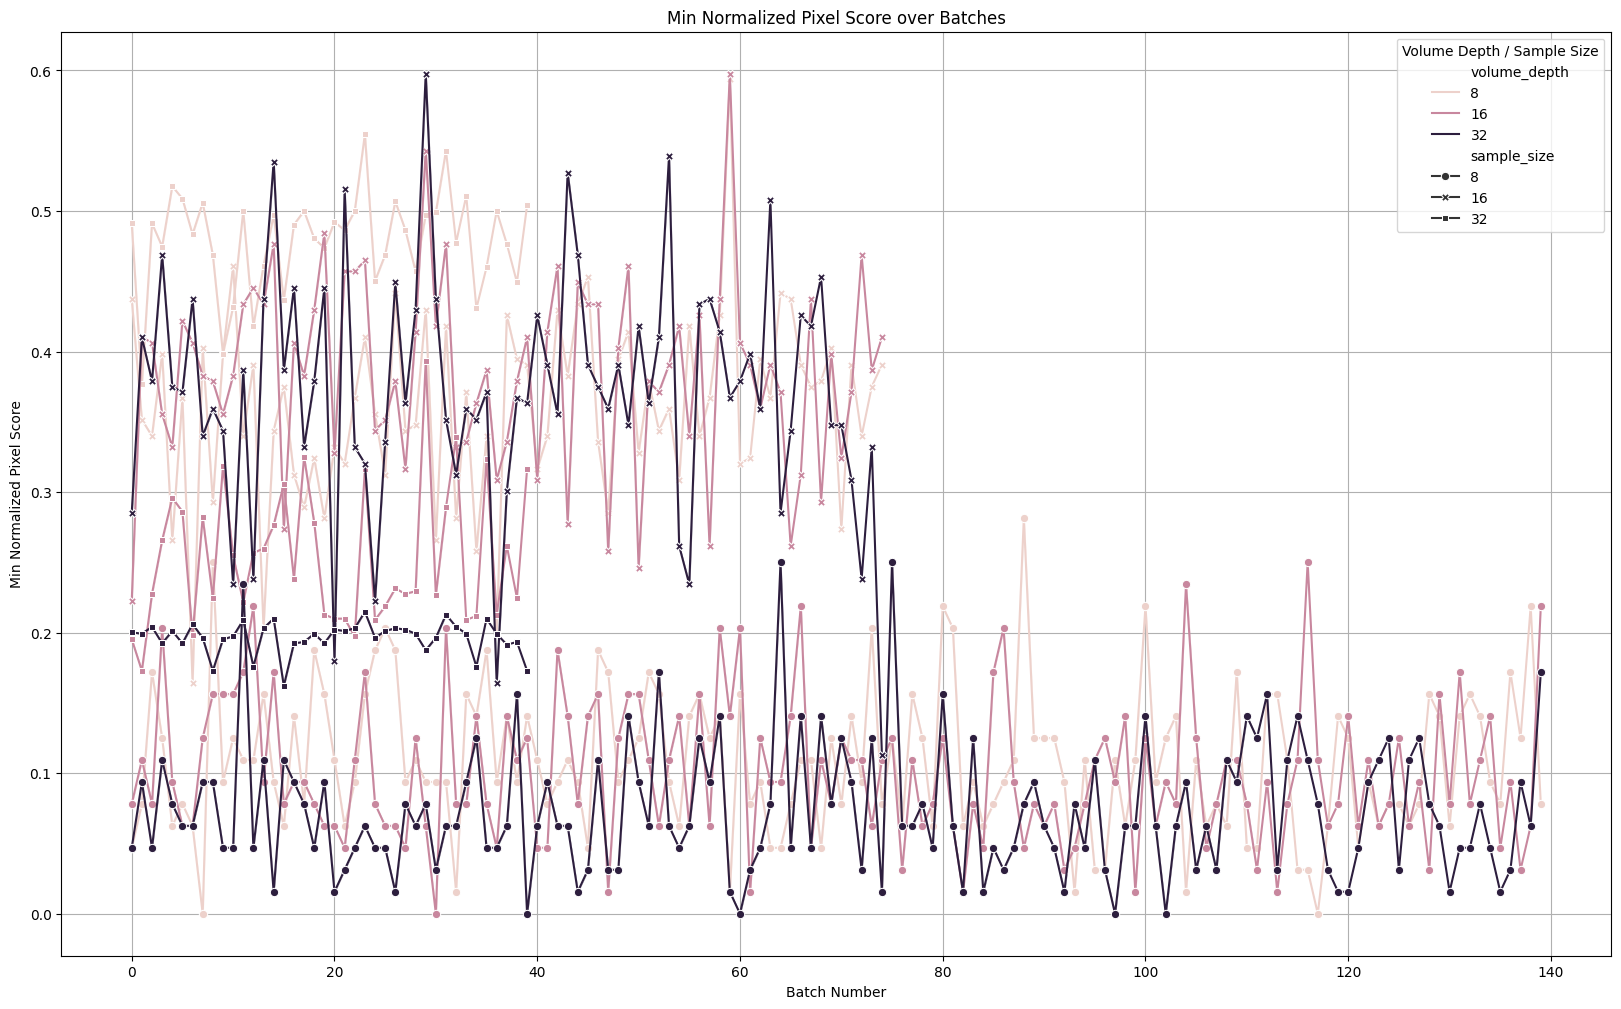

In [11]:

#plot with seaborn lineplot with hue as volume_depth and style as sample_size
import seaborn as sns
plt.figure(figsize=(20, 12))
sns.lineplot(data=df, x="batch_number", y="mean_normalized_pixel_score", hue="volume_depth", style="sample_size", markers=True, dashes=False)
plt.title("Mean Normalized Pixel Score over Batches")
plt.xlabel("Batch Number")
plt.ylabel("Mean Normalized Pixel Score")
plt.legend(title="Volume Depth / Sample Size")
plt.grid()
plt.show()

#same for max
plt.figure(figsize=(20, 12))
sns.lineplot(data=df, x="batch_number", y="max_normalized_pixel_score", hue="volume_depth", style="sample_size", markers=True, dashes=False)
plt.title("Max Normalized Pixel Score over Batches")
plt.xlabel("Batch Number")
plt.ylabel("Max Normalized Pixel Score")
plt.legend(title="Volume Depth / Sample Size")
plt.grid()
plt.show()

#same for min
plt.figure(figsize=(20, 12))
sns.lineplot(data=df, x="batch_number", y="min_normalized_pixel_score", hue="volume_depth", style="sample_size", markers=True, dashes=False)
plt.title("Min Normalized Pixel Score over Batches")
plt.xlabel("Batch Number")
plt.ylabel("Min Normalized Pixel Score")
plt.legend(title="Volume Depth / Sample Size")
plt.grid()
plt.show()

/tmp/ipykernel_2273242/3752016141.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Volume Depth ")


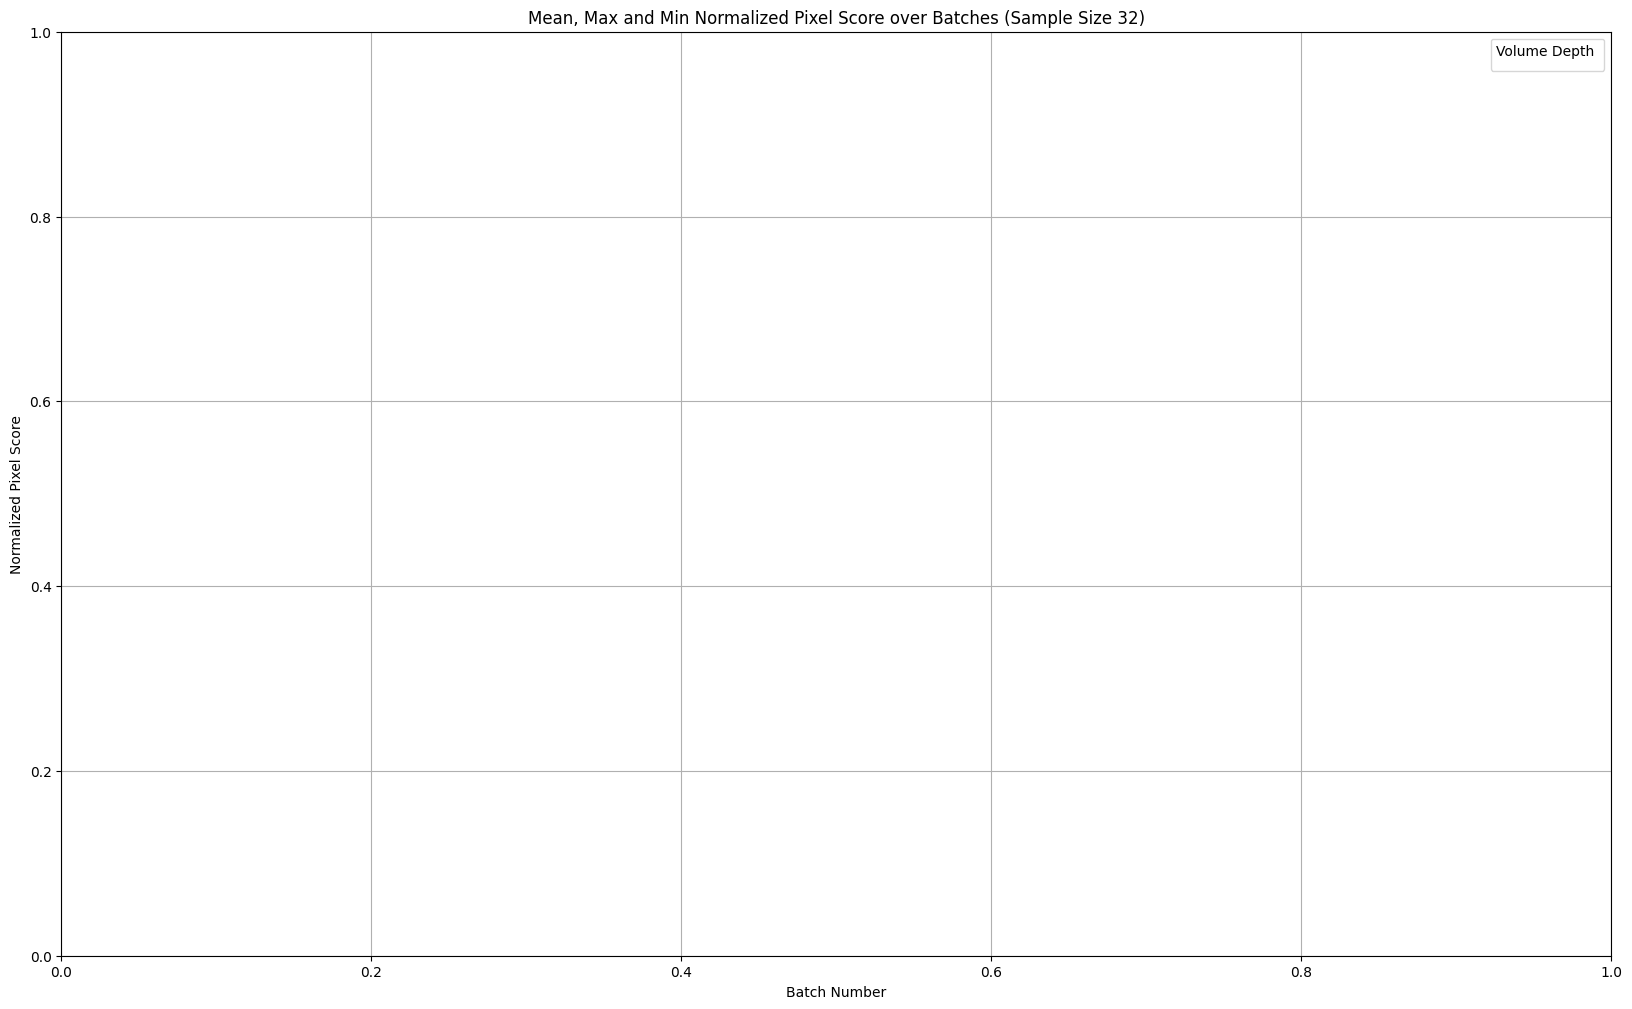

/tmp/ipykernel_2273242/3752016141.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Volume Depth ")


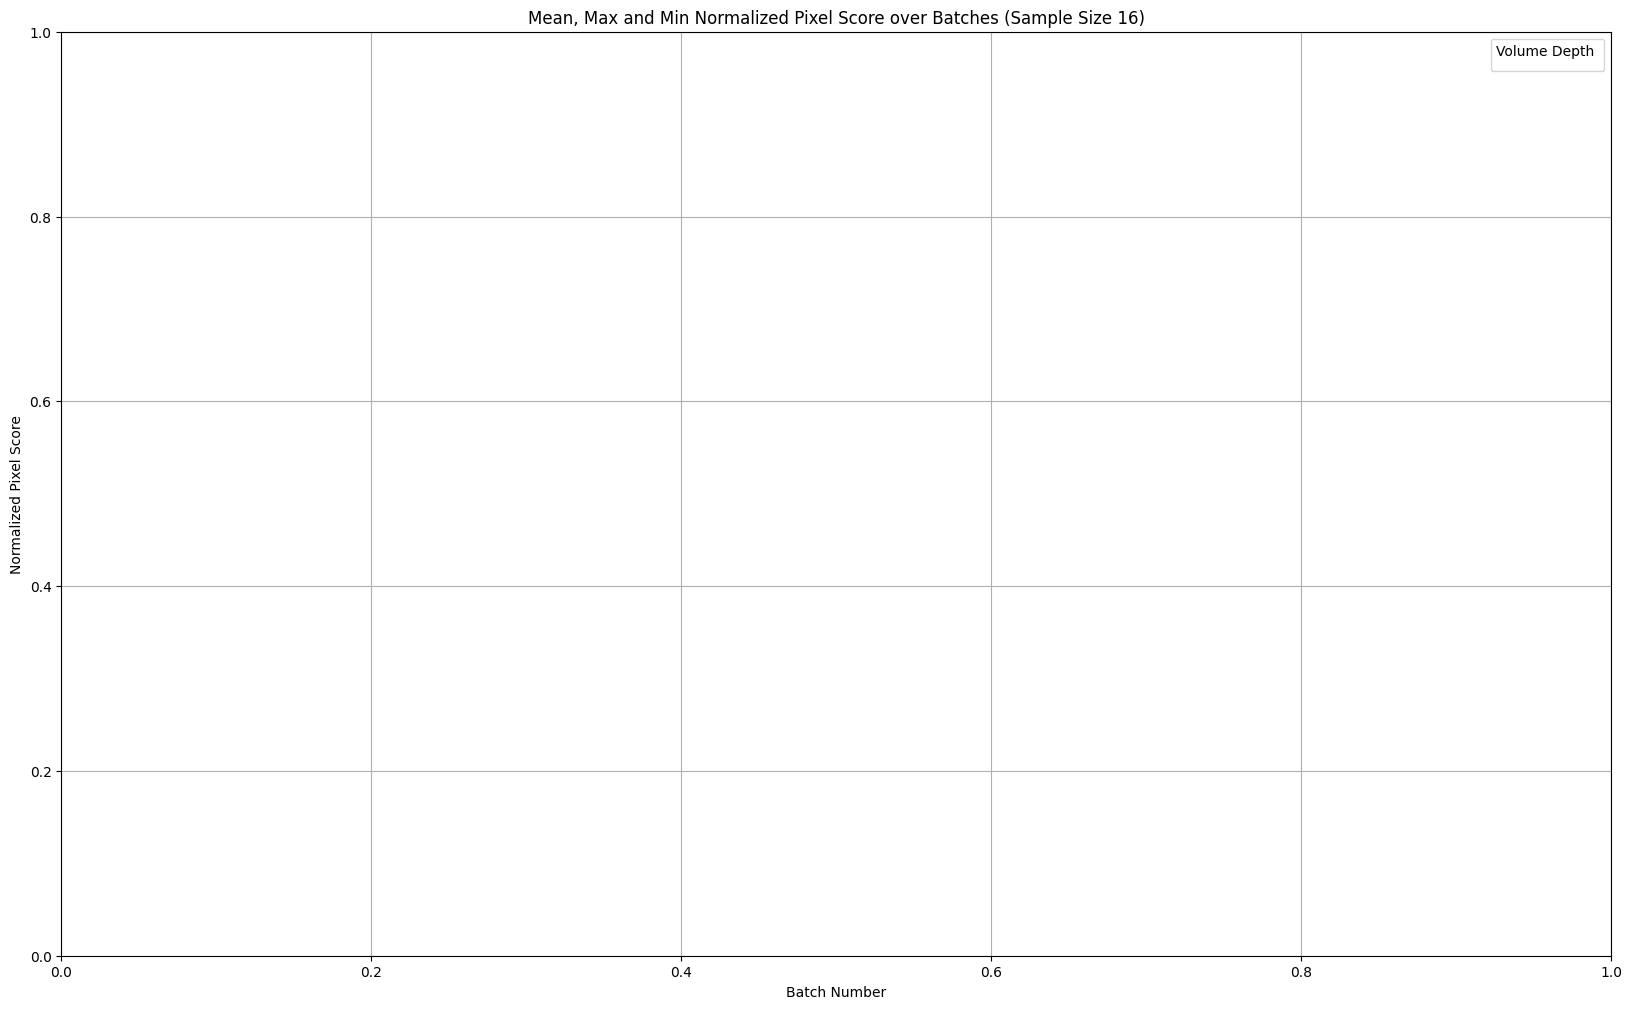

/tmp/ipykernel_2273242/3752016141.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Volume Depth ")


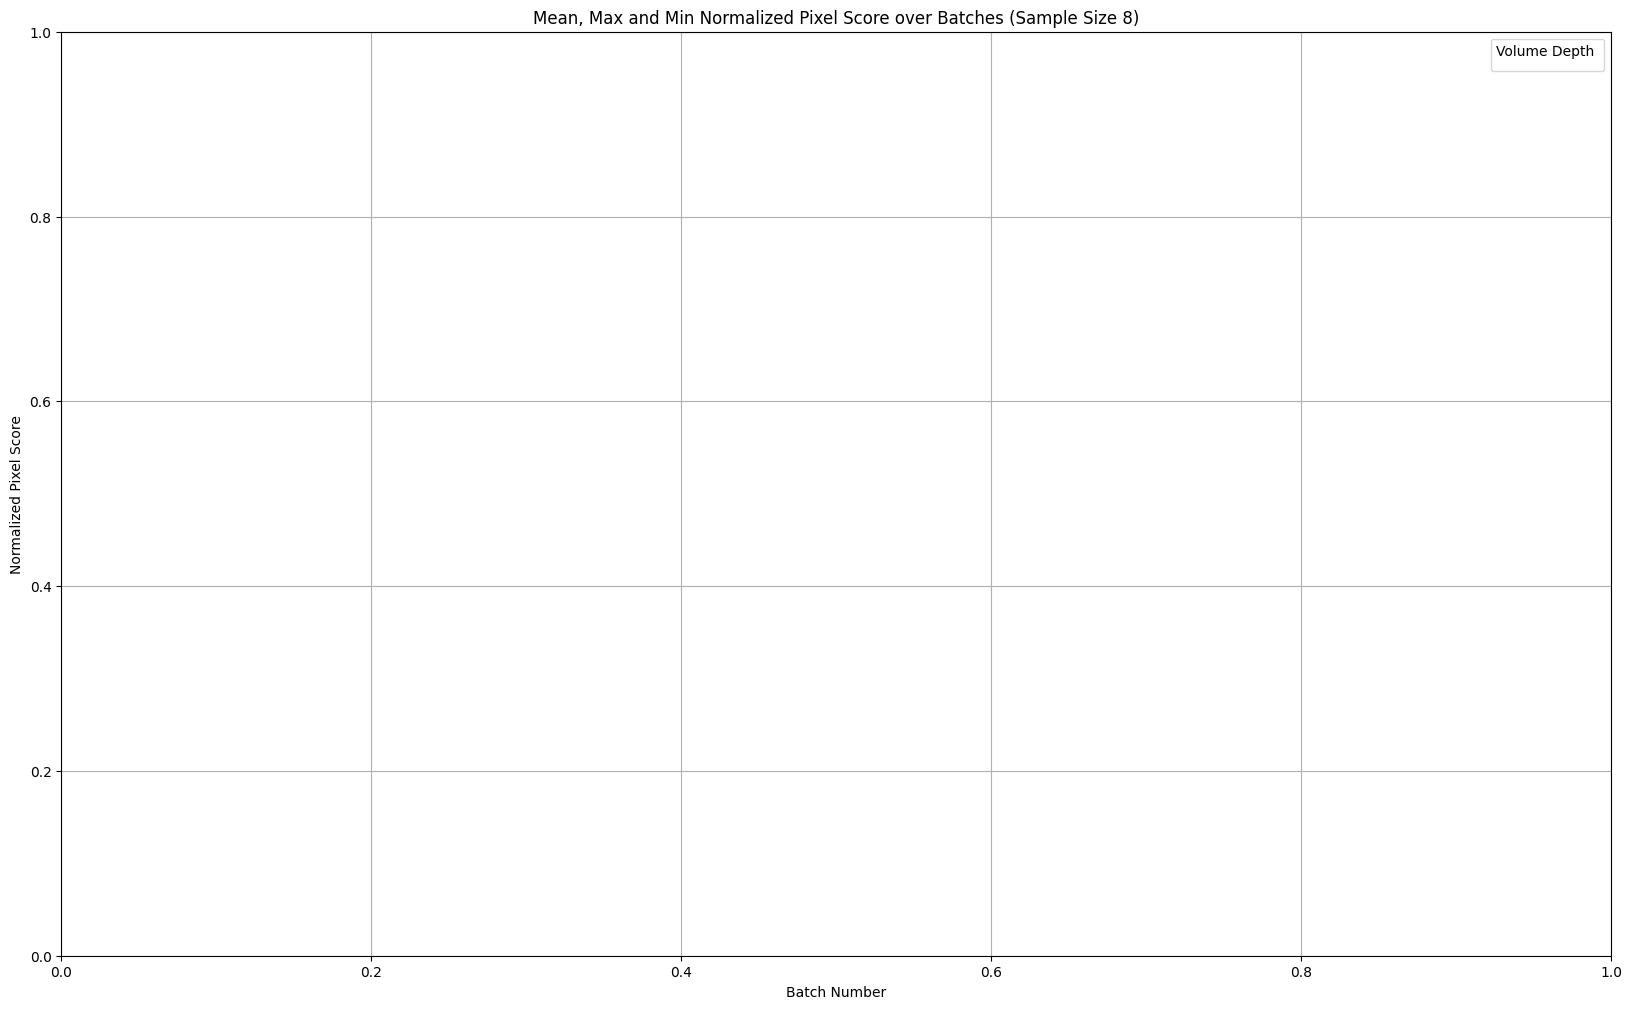

In [12]:
# now mean,max and min only for sample_size 32 in one plot with different hues for each
plt.figure(figsize=(20, 12))
sns.lineplot(data=df[df["sample_size"]=="32"], x="batch_number", y="mean_normalized_pixel_score", style="volume_depth", markers=True, dashes=False)
sns.lineplot(data=df[df["sample_size"]=="32"], x="batch_number", y="max_normalized_pixel_score", style="volume_depth", markers=True, dashes=False)
sns.lineplot(data=df[df["sample_size"]=="32"], x="batch_number", y="min_normalized_pixel_score", style="volume_depth", markers=True, dashes=False)
plt.title("Mean, Max and Min Normalized Pixel Score over Batches (Sample Size 32)")
plt.xlabel("Batch Number")
plt.ylabel("Normalized Pixel Score")
plt.legend(title="Volume Depth ")
plt.grid()
plt.show()

# now mean,max and min only for sample_size 16 in one plot with different hues for each
plt.figure(figsize=(20, 12))
sns.lineplot(data=df[df["sample_size"]=="16"], x="batch_number", y="mean_normalized_pixel_score", style="volume_depth", markers=True, dashes=False)
sns.lineplot(data=df[df["sample_size"]=="16"], x="batch_number", y="max_normalized_pixel_score", style="volume_depth", markers=True, dashes=False)
sns.lineplot(data=df[df["sample_size"]=="16"], x="batch_number", y="min_normalized_pixel_score", style="volume_depth", markers=True, dashes=False)
plt.title("Mean, Max and Min Normalized Pixel Score over Batches (Sample Size 16)")
plt.xlabel("Batch Number")
plt.ylabel("Normalized Pixel Score")
plt.legend(title="Volume Depth ")
plt.grid()
plt.show()

# now mean,max and min only for sample_size 8 in one plot with different hues for each
plt.figure(figsize=(20, 12))
sns.lineplot(data=df[df["sample_size"]=="8"], x="batch_number", y="mean_normalized_pixel_score", style="volume_depth", markers=True, dashes=False)
sns.lineplot(data=df[df["sample_size"]=="8"], x="batch_number", y="max_normalized_pixel_score", style="volume_depth", markers=True, dashes=False)
sns.lineplot(data=df[df["sample_size"]=="8"], x="batch_number", y="min_normalized_pixel_score", style="volume_depth", markers=True, dashes=False)
plt.title("Mean, Max and Min Normalized Pixel Score over Batches (Sample Size 8)")
plt.xlabel("Batch Number")
plt.ylabel("Normalized Pixel Score")
plt.legend(title="Volume Depth ")
plt.grid()
plt.show()

/tmp/ipykernel_2273242/946882529.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Sample Size ")


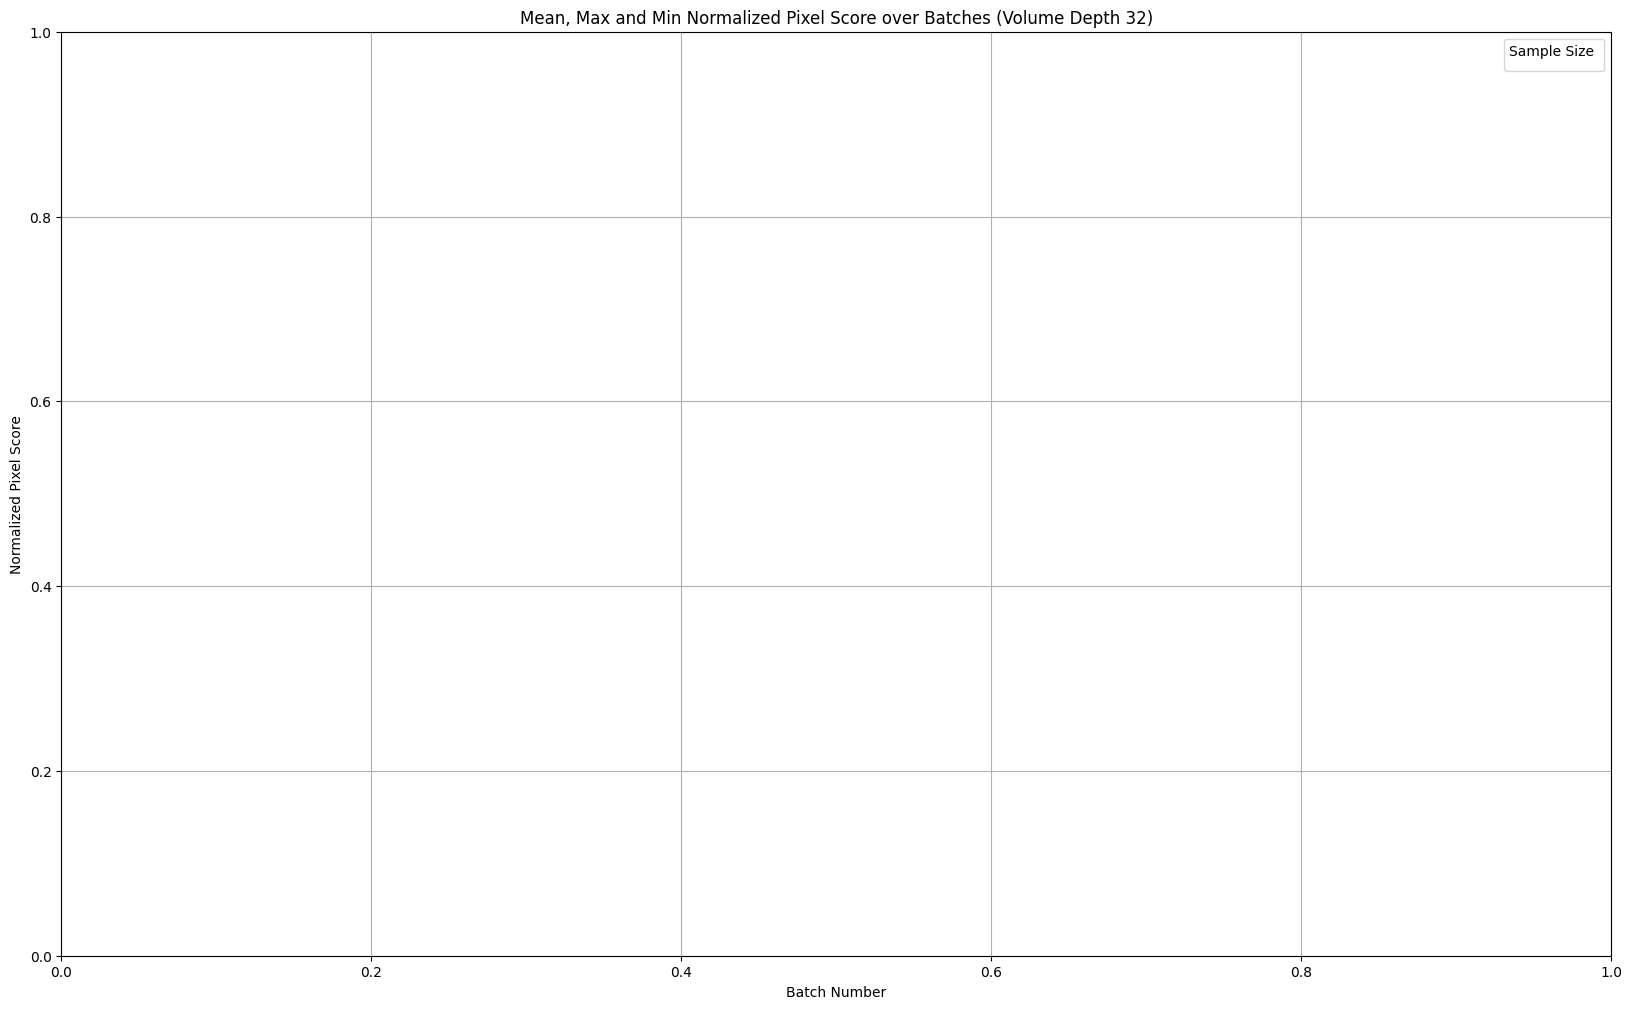

/tmp/ipykernel_2273242/946882529.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Sample Size ")


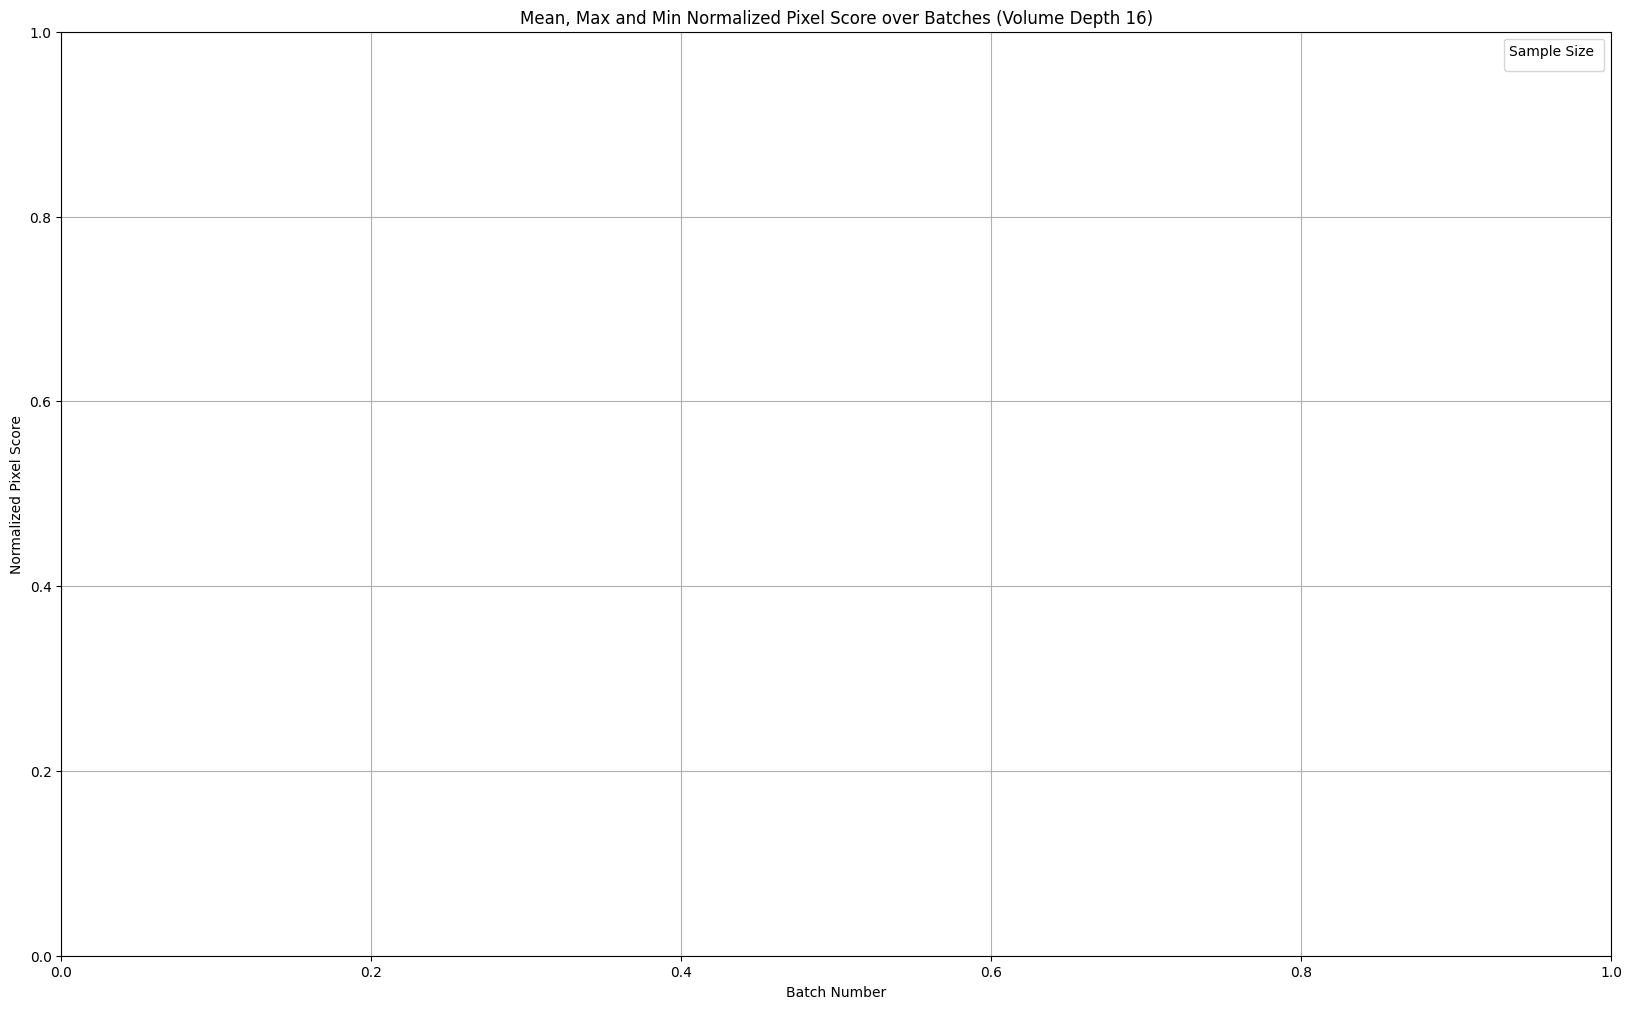

/tmp/ipykernel_2273242/946882529.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Sample Size ")


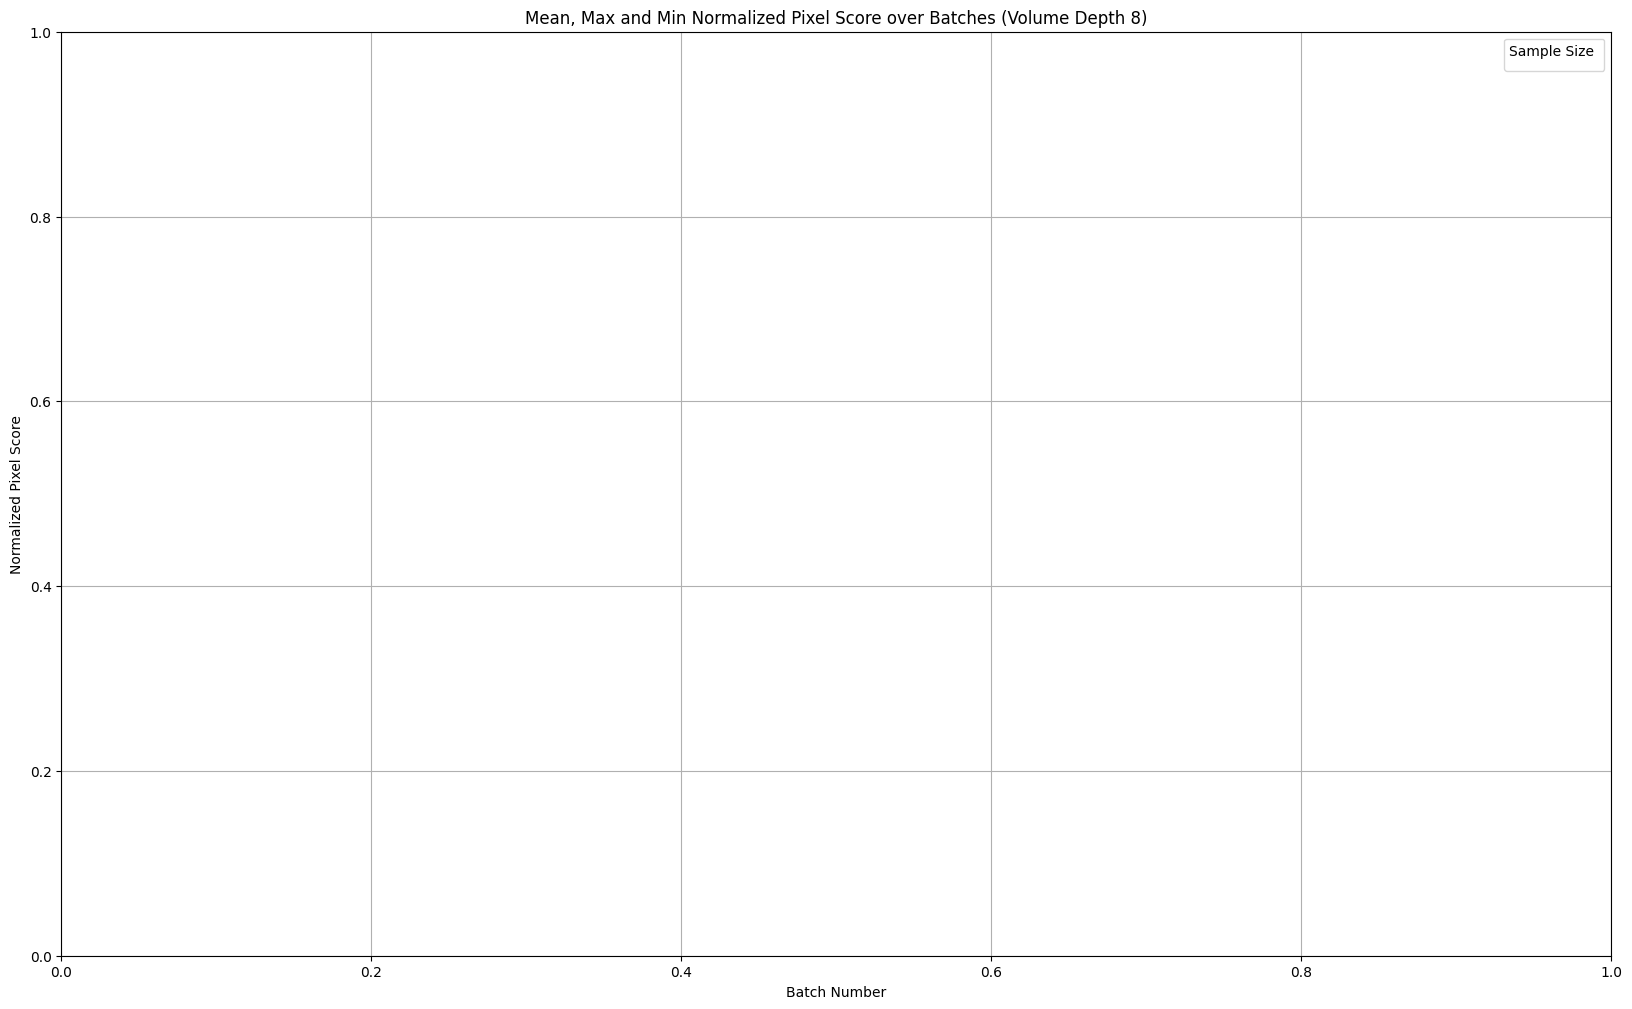

In [13]:
# now mean,max and min only for volume_depth 32 in one plot with different hues for each
plt.figure(figsize=(20, 12))
sns.lineplot(data=df[df["volume_depth"]=="32"], x="batch_number", y="mean_normalized_pixel_score", style="sample_size", markers=True, dashes=False)
sns.lineplot(data=df[df["volume_depth"]=="32"], x="batch_number", y="max_normalized_pixel_score", style="sample_size", markers=True, dashes=False)
sns.lineplot(data=df[df["volume_depth"]=="32"], x="batch_number", y="min_normalized_pixel_score", style="sample_size", markers=True, dashes=False)
plt.title("Mean, Max and Min Normalized Pixel Score over Batches (Volume Depth 32)")
plt.xlabel("Batch Number")
plt.ylabel("Normalized Pixel Score")
plt.legend(title="Sample Size ")
plt.grid()
plt.show()

# now mean,max and min only for volume_depth 16 in one plot with different hues for each
plt.figure(figsize=(20, 12))
sns.lineplot(data=df[df["volume_depth"]=="16"], x="batch_number", y="mean_normalized_pixel_score", style="sample_size", markers=True, dashes=False)
sns.lineplot(data=df[df["volume_depth"]=="16"], x="batch_number", y="max_normalized_pixel_score", style="sample_size", markers=True, dashes=False)
sns.lineplot(data=df[df["volume_depth"]=="16"], x="batch_number", y="min_normalized_pixel_score", style="sample_size", markers=True, dashes=False)
plt.title("Mean, Max and Min Normalized Pixel Score over Batches (Volume Depth 16)")
plt.xlabel("Batch Number")
plt.ylabel("Normalized Pixel Score")
plt.legend(title="Sample Size ")
plt.grid()
plt.show()
# now mean,max and min only for volume_depth 8 in one plot with different hues for each
plt.figure(figsize=(20, 12))
sns.lineplot(data=df[df["volume_depth"]=="8"], x="batch_number", y="mean_normalized_pixel_score", style="sample_size", markers=True, dashes=False)
sns.lineplot(data=df[df["volume_depth"]=="8"], x="batch_number", y="max_normalized_pixel_score", style="sample_size", markers=True, dashes=False)
sns.lineplot(data=df[df["volume_depth"]=="8"], x="batch_number", y="min_normalized_pixel_score", style="sample_size", markers=True, dashes=False)
plt.title("Mean, Max and Min Normalized Pixel Score over Batches (Volume Depth 8)")
plt.xlabel("Batch Number")
plt.ylabel("Normalized Pixel Score")
plt.legend(title="Sample Size ")
plt.grid()
plt.show()